In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

# Prepare all files
Using the word vector created by Shu Wang

In [ ]:
index2word_path = "/content/drive/MyDrive/Colab Notebooks/index2vec.npy" # index2word[idx] = word (list)
word2index_path = "/content/drive/MyDrive/Colab Notebooks//word2index.npy"
index2vec_path = "/content/drive/MyDrive/Colab Notebooks/index2vec.npy"
train_ids_path = "/content/drive/MyDrive/Colab Notebooks/train_ids.npy"
test_ids_path = "/content/drive/MyDrive/Colab Notebooks/test_ids.npy"
y_train_path = "/content/drive/MyDrive/Colab Notebooks/train_labels.npy"
y_test_path = "/content/drive/MyDrive/Colab Notebooks/test_labels.npy"

load data

In [ ]:
x_ids_train = np.load(train_ids_path, allow_pickle=True)
x_ids_test = np.load(test_ids_path, allow_pickle=True)
y_train = np.load(y_train_path, allow_pickle=True)
y_test = np.load(y_test_path, allow_pickle=True)

In [ ]:
# get word vector
index2word = np.load(index2word_path, allow_pickle=True)
word2index = np.load(word2index_path, allow_pickle=True).item()
index2vec = np.load(index2vec_path, allow_pickle=True)

Check length of each. There should not be output.

In [ ]:
if len(index2word) != 247241 or len(word2index) != 247241 or len(index2vec) != 247241:
    print('error')

# Build the model (CNN)
Using pytorch to build the CNN model.

In [ ]:
import torchtext
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,TensorDataset
from torchtext import data,datasets

Use 1-dimensional convolutional layers, where the embedding dimension is the 
"depth" of the filter and the number of tokens in the sentence is the width.

In [ ]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        # embedding_dim=100, which means the dim of each word vector
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)    # Avoid overfitting dropout=0.5
        
    def forward(self, text):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
       
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]  # using ReLu activation
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  # using max pooling to find the 'most important' feature
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))  # avoid overfitting, dropout=0.5
        
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)
    

Test whether can use GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size = 512

test_data = TensorDataset(torch.from_numpy(x_ids_test).to(device), torch.from_numpy(y_test).to(device))

train_data = x_ids_train[:1700000]    # train_data size = 1700000
valid_data = x_ids_train[1700000:]
y_train_data = y_train[:1700000]    # validation_data size = 100000
y_valid_data = y_train[1700000:]

train_data = TensorDataset(torch.from_numpy(train_data).to(device), torch.from_numpy(y_train_data).to(device))
valid_data = TensorDataset(torch.from_numpy(valid_data).to(device), torch.from_numpy(y_valid_data).to(device))


train_iterator = torch.utils.data.DataLoader(train_data, 
                                             batch_size, 
                                             shuffle = True, 
                                             )
valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size, 
                                             shuffle = True, 
                                             )
test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size, 
                                            shuffle = False, 
                                            )

Set the parameters.

In [ ]:
INPUT_DIM = len(word2index)
EMBEDDING_DIM = 100   # the dim of each word vector
N_FILTERS = 150   # total = 150 * 4 = 600
FILTER_SIZES = [2,3,4,5]  #  four different sizes of filters to cover 2, 3, 4, 5 sequential words
OUTPUT_DIM = 1  # only one output of the probability
DROPOUT = 0.5  # avoid overfitting
PAD_IDX = word2index['<pad>']

model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

Load the pre-trained embeddings.

In [ ]:
embedding_matrix = torch.from_numpy(index2vec)
model.embedding.weight.data.copy_(embedding_matrix)

tensor([[ 0.5362, -1.3032,  1.0179,  ...,  0.8529, -1.2968,  1.5806],
        [-0.2687, -0.3067,  1.4581,  ..., -0.0285, -0.5613, -0.7968],
        [ 1.2081, -1.2739, -0.5806,  ...,  0.9084, -0.2043,  0.5994],
        ...,
        [ 0.0245,  0.2965, -0.1585,  ...,  0.0347,  0.0736, -0.0479],
        [-0.0387,  0.0784, -0.0191,  ...,  0.0271, -0.0750,  0.0445],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

# Train the Model
Initialize the optimizer (Adam), loss function (BCEWithLogitsLoss) and place the model

In [ ]:
import torch.optim as optim
# Define the loss function and optimize the method
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()    # as this is a binary classification
#criterion = nn.CrossEntropyLoss()     cross entropy is less effective as BCE

model = model.to(device)
criterion = criterion.to(device)

Define a function for training the model.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:    # batch = [text, label]

        text = batch[0]

        label = batch[1].float()

        optimizer.zero_grad() # The gradient calculation result of the previous batch is not required when the next batch gradient calculation is performed

        predictions = model(text).squeeze(1)

        round_pred = torch.round(torch.sigmoid(predictions))    # to make the output between 0 to 1
        
        loss = criterion(predictions, label)  # nn.BCEWithLogitsLoss() 

        correct = (round_pred == label).float()

        acc = correct.sum() / len(correct)  # Calculate accuracy, which will return accuracy every patch

        #print(f'\tTrain Loss: {loss:.3f} | Train Acc: {acc*100:.2f}%')
        
        loss.backward()   # loss derivative
        
        optimizer.step()  # Update parameters
        
        epoch_loss += loss.item()   # tensor.item() gets the value of tensor
        epoch_acc += acc.item()

        loss = epoch_loss / len(iterator) # calculate loss and accuracy
        acc = epoch_acc / len(iterator)
        
    return loss, acc

Define a function for testing the model.

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    predic = []

    with torch.no_grad(): # will not track the gradient
    
        for batch in iterator:

            text = batch[0]

            label = batch[1].float()

            predictions = model(text).squeeze(1)

            round_pred = torch.round(torch.sigmoid(predictions))

            predic.append(round_pred)
            
            loss = criterion(predictions, label)

            correct = (round_pred == label).float()

            acc = correct.sum() / len(correct)      

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            loss = epoch_loss / len(iterator)
            acc = epoch_acc / len(iterator)
        
    return loss, acc, predic

Start training the model.

After training the model with different epochs, I set the number of epochs to 4 to avoid overfitting.

In [ ]:
N_EPOCHS = 4

best_valid_loss = float('inf')

trainloss = []
trainacc = []
vloss = []
vacc = []
epo = []

for epoch in range(N_EPOCHS):
    epo.append(epoch + 1)
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_label = evaluate(model, valid_iterator, criterion)
    # reocrd loss and accuracy in each epoch
    trainloss.append(train_loss)
    trainacc.append(train_acc)
    vloss.append(valid_loss)
    vacc.append(valid_acc)  
    torch.save(model.state_dict(), './CNN_good_model.pt')
 
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.219 | Train Acc: 91.24%
	 Val. Loss: 0.172 |  Val. Acc: 93.45%
Epoch: 02
	Train Loss: 0.170 | Train Acc: 93.54%
	 Val. Loss: 0.162 |  Val. Acc: 93.92%
Epoch: 03
	Train Loss: 0.153 | Train Acc: 94.30%
	 Val. Loss: 0.156 |  Val. Acc: 94.25%
Epoch: 04
	Train Loss: 0.142 | Train Acc: 94.80%
	 Val. Loss: 0.157 |  Val. Acc: 94.18%


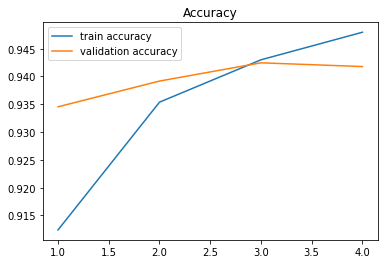

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(epo,trainacc,label = "train accuracy")
plt.plot(epo,vacc,label = "validation accuracy")

plt.legend()
plt.title('Accuracy')
plt.show()

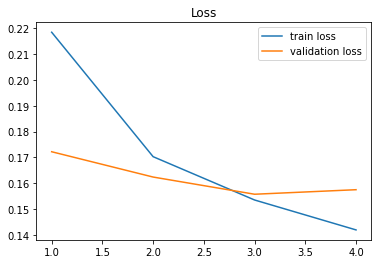

In [ ]:
plt.plot(epo,trainloss,label = "train loss")
plt.plot(epo,vloss,label = "validation loss")
plt.legend()
plt.title('Loss')
plt.show()

# Final result

In [ ]:
test_loss, test_acc, test_pred = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.158 | Test Acc: 94.19%


In [ ]:
list1 = []
for i in test_pred:
  for j in i:
    list1.append(j)

In [ ]:
ytest = torch.from_numpy(y_test).cpu()
list2 = torch.tensor(list1).cpu()
from sklearn.metrics import f1_score, confusion_matrix, classification_report
matrix = classification_report(ytest, list2,labels=[1,0], zero_division=0.0)
print('Classification matrix : \n',confusion_matrix(ytest, list2))
print('\nClassification report : \n',matrix)

Classification matrix : 
 [[93168  6930]
 [ 4676 95226]]

Classification report : 
               precision    recall  f1-score   support

           1       0.93      0.95      0.94     99902
           0       0.95      0.93      0.94    100098

    accuracy                           0.94    200000
   macro avg       0.94      0.94      0.94    200000
weighted avg       0.94      0.94      0.94    200000



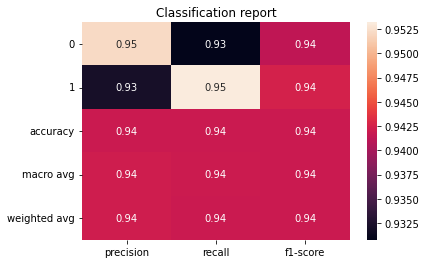

In [ ]:
import seaborn as sns
sns.heatmap(pd.DataFrame(classification_report(
         ytest, list2, zero_division=0.0,output_dict=True)).iloc[:-1, :].T, annot=True)
plt.title('Classification report')
plt.show()

## Model analysis
From the confusion matrix and classification report, it shows that the data set is balanced, so it can achieve high accuracy. On the other hand, if the data set is imbalanced, we may use much data to train the model.
In this task, I manually choose the parameters to find the best model, and in the future, I can use cross validation such as k-fold for hyper-parameters tuning, which will be more effective and more correct.
Furthermore, I can try to use keras and tensorflow to build the model, which is different from pytorch, but is also effective in machine learning and deep learning.